In [ ]:
# pip install seaborn

In [1]:
# Import our dependencies
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
import pandas as pd
import tensorflow as tf
import seaborn as sns
import matplotlib.pyplot as plt
import os
#  Import and read the charity_data.csv.
application_df = pd.read_csv("Resources/charity_data.csv")
application_df.head()

,EIN,NAME,APPLICATION_TYPE,AFFILIATION,CLASSIFICATION,USE_CASE,ORGANIZATION,STATUS,INCOME_AMT,SPECIAL_CONSIDERATIONS,ASK_AMT,IS_SUCCESSFUL
0,10520599,BLUE KNIGHTS MOTORCYCLE CLUB,T10,Independent,C1000,ProductDev,Association,1,0,N,5000,1
1,10531628,AMERICAN CHESAPEAKE CLUB CHARITABLE TR,T3,Independent,C2000,Preservation,Co-operative,1,1-9999,N,108590,1
2,10547893,ST CLOUD PROFESSIONAL FIREFIGHTERS,T5,CompanySponsored,C3000,ProductDev,Association,1,0,N,5000,0
3,10553066,SOUTHSIDE ATHLETIC ASSOCIATION,T3,CompanySponsored,C2000,Preservation,Trust,1,10000-24999,N,6692,1
4,10556103,GENETIC RESEARCH INSTITUTE OF THE DESERT,T3,Independent,C1000,Heathcare,Trust,1,100000-499999,N,142590,1


In [2]:
# Drop the non-beneficial ID columns, 'EIN' and 'NAME'.
application_df = application_df.drop(['EIN', 'NAME'], axis=1)
# Choose a cutoff value and create a list of application types to be replaced
# use the variable name `application_types_to_replace`
cutoff = 1000
application_counts = application_df['APPLICATION_TYPE'].value_counts()
application_types_to_replace = list(application_counts[application_counts < cutoff].index)
# Replace in dataframe
for app in application_types_to_replace:
    application_df['APPLICATION_TYPE'] = application_df['APPLICATION_TYPE'].replace(app,"Other")
# Group low-frequency AFFILIATION categories
low_freq_categories = ['Family/Parent', 'National', 'Regional', 'Other']
application_df['AFFILIATION'] = application_df['AFFILIATION'].apply(lambda x: 'Other' if x in low_freq_categories else x)
# Choose a cutoff value and create a list of classifications to be replaced
# use the variable name `classifications_to_replace`
cutoff = 1000
classification_counts = application_df['CLASSIFICATION'].value_counts()
classifications_to_replace = list(classification_counts[classification_counts < cutoff].index)
# Replace in dataframe
for cls in classifications_to_replace:
    application_df['CLASSIFICATION'] = application_df['CLASSIFICATION'].replace(cls,"Other")
# Group low-frequency USE_CASE categories
low_freq_categories = ['CommunityServ', 'Heathcare', 'Other']
application_df['USE_CASE'] = application_df['USE_CASE'].apply(lambda x: 'Other' if x in low_freq_categories else x)
# Group low-frequency ORGANIZATION categories
low_freq_categories = ['Co-operative', 'Corporation']
application_df['ORGANIZATION'] = application_df['ORGANIZATION'].apply(lambda x: 'Other' if x in low_freq_categories else x)
# Drop the STATUS Column
application_df = application_df.drop(['STATUS'], axis=1)
# Convert the INCOME_AMT column to a categorical variable
income_categories = ['0', '1M-5M', '100000-499999', '10M-50M', '25000-99999', '5M-10M', '10000-24999', '50M+']
application_df['INCOME_AMT'] = pd.Categorical(application_df['INCOME_AMT'], categories=income_categories, ordered=True)
# Replace missing values with the mode
income_mode = application_df['INCOME_AMT'].mode()[0]
application_df['INCOME_AMT'].replace(['1/01/9999'], income_mode, inplace=True)
# One-hot encode the INCOME_AMT column
income_dummies = pd.get_dummies(application_df['INCOME_AMT'], prefix='INCOME')
application_df = pd.concat([application_df, income_dummies], axis=1)
# Drop the original INCOME_AMT column
application_df.drop(['INCOME_AMT'], axis=1, inplace=True)
# Drop the SPECIAL_CONSIDERATIONS Column
application_df = application_df.drop(['SPECIAL_CONSIDERATIONS'], axis=1)
# Initialize the MinMaxScaler
scaler = MinMaxScaler()
# Reshape the feature to a 2D array and fit the scaler to the data
ask_amt = application_df["ASK_AMT"].values.reshape(-1, 1)
scaler.fit(ask_amt)
# Transform the feature using the scaler
scaled_ask_amt = scaler.transform(ask_amt)
# Replace the original feature in the DataFrame with the scaled feature
application_df["ASK_AMT"] = scaled_ask_amt
# Convert categorical data to numeric with `pd.get_dummies`
application_df = pd.get_dummies(application_df, columns=['AFFILIATION','CLASSIFICATION', 'USE_CASE', 'ORGANIZATION', 'APPLICATION_TYPE'])
application_df.head()

,ASK_AMT,IS_SUCCESSFUL,INCOME_0,INCOME_1M-5M,INCOME_100000-499999,INCOME_10M-50M,INCOME_25000-99999,INCOME_5M-10M,INCOME_10000-24999,INCOME_50M+,...,USE_CASE_ProductDev,ORGANIZATION_Association,ORGANIZATION_Other,ORGANIZATION_Trust,APPLICATION_TYPE_Other,APPLICATION_TYPE_T19,APPLICATION_TYPE_T3,APPLICATION_TYPE_T4,APPLICATION_TYPE_T5,APPLICATION_TYPE_T6
0,0.000000e+00,1,1,0,0,0,0,0,0,0,...,1,1,0,0,1,0,0,0,0,0
1,1.204843e-05,1,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,1,0,0,0
2,0.000000e+00,0,1,0,0,0,0,0,0,0,...,1,1,0,0,0,0,0,0,1,0
3,1.967945e-07,1,0,0,0,0,0,0,1,0,...,0,0,0,1,0,0,1,0,0,0
4,1.600293e-05,1,0,0,1,0,0,0,0,0,...,0,0,0,1,0,0,1,0,0,0


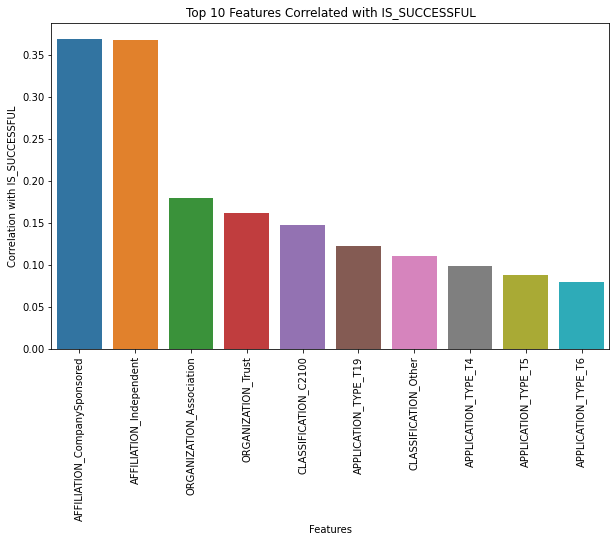

In [3]:
# Calculate the correlation between each feature and the target variable
corr_matrix = application_df.corr()['IS_SUCCESSFUL']

# Sort the correlations in descending order and select the top N features
n_features = 10
top_corr_features = corr_matrix.abs().sort_values(ascending=False)[1:n_features+1]

# Set the figure size
plt.figure(figsize=(10, 6))

# Plot a bar chart of the top N features
ax = sns.barplot(x=top_corr_features.index, y=top_corr_features)

# Customize the plot
plt.xticks(rotation=90)
plt.xlabel('Features')
plt.ylabel('Correlation with IS_SUCCESSFUL')
plt.title(f'Top {n_features} Features Correlated with IS_SUCCESSFUL')

# Create an Images folder if it does not exist
if not os.path.exists('Images'):
    os.makedirs('Images')

# Save the plot as a PNG image file in the Images folder
plt.savefig('Images/correlation_plot230327.png', dpi=350, bbox_inches='tight')

# Display the plot
plt.show()

In [4]:
# Split our preprocessed data into our features and target arrays
y = application_df['IS_SUCCESSFUL'].values
X = application_df.drop('IS_SUCCESSFUL', axis=1).values
# Split the preprocessed data into a training and testing dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=78)

# Create a StandardScaler instances
scaler = StandardScaler()
# Fit the StandardScaler
X_scaler = scaler.fit(X_train)
# Scale the data
X_train_scaled = X_scaler.transform(X_train)
X_test_scaled = X_scaler.transform(X_test)

In [5]:
# Define the model - deep neural net
nn = tf.keras.models.Sequential()

# Add input layer
nn.add(tf.keras.layers.Dense(units=9, input_dim=30, activation="tanh"))

# Add hidden layers with dropout regularization
nn.add(tf.keras.layers.Dense(units=5, activation="tanh"))
nn.add(tf.keras.layers.Dropout(0.3))
nn.add(tf.keras.layers.Dense(units=7, activation="tanh"))
nn.add(tf.keras.layers.Dropout(0.2))
nn.add(tf.keras.layers.Dense(units=7, activation="tanh"))
nn.add(tf.keras.layers.Dropout(0.2))

# Add output layer
nn.add(tf.keras.layers.Dense(units=1, activation="sigmoid"))

# Print the model summary
nn.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 9)                 279       
                                                                 
 dense_1 (Dense)             (None, 5)                 50        
                                                                 
 dropout (Dropout)           (None, 5)                 0         
                                                                 
 dense_2 (Dense)             (None, 7)                 42        
                                                                 
 dropout_1 (Dropout)         (None, 7)                 0         
                                                                 
 dense_3 (Dense)             (None, 7)                 56        
                                                                 
 dropout_2 (Dropout)         (None, 7)                 0

In [ ]:
# pip install pydot

In [9]:
# Visualize the model architecture
from keras.utils.vis_utils import plot_model
plot_model(nn, to_file='Images/model_architecture.png', show_shapes=True)

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.


In [7]:
from keras.callbacks import History
# Compile the model
nn.compile(loss="binary_crossentropy", optimizer="RMSprop", metrics=["accuracy"])

# Train the model
batch_size = 64
epochs = 50
history = History()
nn.fit(X_train_scaled, y_train, batch_size=batch_size, epochs=epochs, validation_split=0.2,callbacks=[history],verbose=1)

Epoch 1/50
322/322 [==============================] - 2s 4ms/step - loss: 0.6708 - accuracy: 0.5885 - val_loss: 0.6144 - val_accuracy: 0.6820
Epoch 2/50
322/322 [==============================] - 1s 3ms/step - loss: 0.6190 - accuracy: 0.6855 - val_loss: 0.5923 - val_accuracy: 0.7094
Epoch 3/50
322/322 [==============================] - 1s 3ms/step - loss: 0.5958 - accuracy: 0.7166 - val_loss: 0.5862 - val_accuracy: 0.7176
Epoch 4/50
322/322 [==============================] - 1s 3ms/step - loss: 0.5923 - accuracy: 0.7233 - val_loss: 0.5831 - val_accuracy: 0.7219
Epoch 5/50
322/322 [==============================] - 1s 3ms/step - loss: 0.5872 - accuracy: 0.7256 - val_loss: 0.5794 - val_accuracy: 0.7238
Epoch 6/50
322/322 [==============================] - 1s 3ms/step - loss: 0.5821 - accuracy: 0.7271 - val_loss: 0.5769 - val_accuracy: 0.7234
Epoch 7/50
322/322 [==============================] - 1s 3ms/step - loss: 0.5792 - accuracy: 0.7280 - val_loss: 0.5751 - val_accuracy: 0.7234
Epoch 

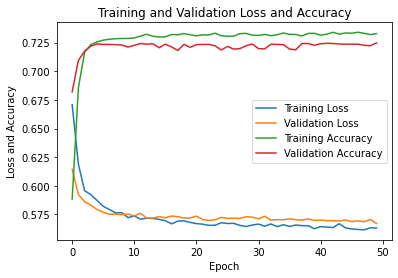

In [8]:
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Loss and Accuracy')
plt.title('Training and Validation Loss and Accuracy')
plt.legend()
plt.savefig('Images/loss_acc_plot.png', dpi=300, bbox_inches='tight')